# Trend of popular YouTube food videos

***Target client:***

YouTubers who want to check if their idea would be popular or examine if their titles are apealing enough.


***Data:***

* YouTube in past one year (top 50 videos every week) 

* ...


***Goal:***

* Heroku app 

* Input: 
    topics/keywords/title/description/

* Return:  

   1. trend of several keywords they provide 

   2. predict whether it will be popular 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import requests
import pandas as pd, numpy as np
import datetime 
#from langdetect import detect
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from googletrans import Translator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from sklearn import base
import sklearn
from nltk import pos_tag
lemmatizer = WordNetLemmatizer() 
analyzer = SentimentIntensityAnalyzer()

# get data

In [3]:
# get top 50 videos according to viewCount, under the topic name 'food'
# over a given time period
def search(maxresult,t1,t2,key,q):      
    r = requests.get(
    "https://www.googleapis.com/youtube/v3/search",
        params={'part':'snippet','topicId':'/m/02wbm',
                'regionCode':'US','order':'viewCount',
        'maxResults':maxresult,'publishedAfter':t1,'type':'video',
                'publishedBefore':t2,'q':q,'key':key})
    #return r.json()
    x = [[item['id']['videoId'],item['snippet']['title'],
        item['snippet']['description'],item['snippet']['publishTime'],
            item['snippet']['channelTitle'],
    item['snippet']['channelId']] for item in r.json()['items']]
    content = pd.DataFrame(x,columns=['id','title','description',
    'publishTime','channelTitle','channelId'],index=range(len(x)))
    return content

In [4]:
# get the statisitics of the video of knowing videoId
def get_statistics(videoId,key):
    r1 = requests.get(
    "https://www.googleapis.com/youtube/v3/videos",
            params={'part':'statistics','id':videoId,'key':key})
    return r1.json()['items'][0]['statistics']

In [5]:
# get top 50 comments from a video 
import time
def get_comments(videoId,key):
    comments = []
    #print (videoId)
    r2 = requests.get(
    "https://www.googleapis.com/youtube/v3/commentThreads",
            params={'part':'snippet','videoId':videoId,
                'maxResults':50,'textFormat':'plainText','key':key})
    
    if str(r2.status_code)[0] == '2':
        #print (r2.json(),videoId)
        items = r2.json()['items']
        for j in range(len(items)):
            commenttext = items[j]['snippet']['topLevelComment']['snippet']['textOriginal']
        #if re.match(r'[A-Za-z]+',commenttext):
        #    print (commenttext)
            #if detect(commenttext) == 'en':
                
            comments.append(commenttext)
    return comments


In [6]:
def get_channel_information(channelId,key):
    r3 = requests.get(
    "https://www.googleapis.com/youtube/v3/channels",
            params={'part':'statistics','id':channelId,'key':key})
    return r3.json()['items'][0]['statistics']

In [7]:
# add comment and statistics to the data frame 
def add_comment_and_statistic(x,key):
    viewCount, likeCount, dislikeCount, favoriteCount, commentCount = [],[],[],[],[]
    comments = []
    channel_viewCount, channel_commentCount, channel_subscriber,channel_videoCount = [],[],[],[]
    for i in range(len(x)):
        statistics = get_statistics(x['id'][i],key)
        channel_statistics = get_channel_information(x['channelId'][i],key)
        if ('commentCount' not in statistics) or statistics['commentCount']=='0':
            comments.append([])
        else:
            comments.append(get_comments(x['id'][i],key))
        viewCount.append(float(statistics.get('viewCount',np.nan)))
        likeCount.append(float(statistics.get('likeCount',np.nan)))
        dislikeCount.append(float(statistics.get('dislikeCount',np.nan)))
        favoriteCount.append(float(statistics.get('favoriteCount',np.nan)))
        commentCount.append(float(statistics.get('commentCount',np.nan)))
        channel_viewCount.append(float(channel_statistics.get('viewCount',np.nan)))
        channel_commentCount.append(float(channel_statistics.get('commentCount',np.nan)))
        channel_subscriber.append(float(channel_statistics.get('subscriberCount',np.nan)))
        channel_videoCount.append(float(channel_statistics.get('videoCount',np.nan)))
        
    x['viewCount'] = viewCount
    x['likeCount'] = likeCount
    x['dislikeCount'] = dislikeCount
    x['favoriteCount'] = favoriteCount
    x['commentCount'] = commentCount
    x['comments'] = comments
    x['channel_viewCount'] = channel_viewCount
    x['channel_commentCount'] = channel_commentCount
    x['channel_subscriber'] = channel_subscriber
    x['channel_videoCount'] = channel_videoCount
    
    return x

In [8]:
# turn datetime to RFC-3339 mode
def RFC_3339(t):
    return t.isoformat("T") + "Z"

In [9]:
# search, add statistics and add comments 
def get_daily_youtube_data(x1,q,days,n):
    try:
        key
    except NameError:
        with open('app/youtube.nogit', 'r') as f:
            key = f.read()
    x2 = x1+datetime.timedelta(days=days)
    x = search(n,RFC_3339(x1),RFC_3339(x2),key,q)
    x = add_comment_and_statistic(x,key)
    return x

# process data

In [10]:
def viewratio(x):
    x['viewratio']=x['viewCount']/(x['channel_viewCount']/x['channel_videoCount'])
    x['likeratio']=x['likeCount']/x['viewCount']

In [11]:
def sentiment_study(x):
    c = np.ones([len(x),50])*np.nan
    for i in range(len(x)):
        comments = x.comments[i]
        for j in range(len(comments)):
            c[i,j] =analyzer.polarity_scores(comments[j])['compound']
    x['comment_sentiment'] = np.nanmean(c,axis=1)

In [ ]:
cache = {}

In [52]:

def translate(text):
    time.sleep(1)
    translator = Translator()
    text = re.sub(r'&amp|&quot|http','',text)
    
    if text not in cache:
        print (text)
        cache[text] = translator.translate(text).text
    return cache[text]
    

In [13]:
def trans_title_desp(x):
    new_titles = []
    for title in x['title']:
        new_titles.append(translate(title))
    x['title_trans'] = new_titles
    new_description = []
    for description in x['description']:
        new_description.append(' ')
    x['description_trans']=new_description

In [14]:
def identify_keywords(string):
    text = word_tokenize(string.lower())
    kw = list(set([lemmatizer.lemmatize(a) for a,b in pos_tag(text) if b in ['NN','NNS']]))
    kw = [k for k in kw if re.match(r'^\w\w+$',k)]
    return kw

In [15]:
def get_keywords(x):
    title_trans = x['title_trans']
    title_kw = []
    for t in title_trans:
        title_kw.append(identify_keywords(t))
    description_trans = x['description_trans']
    description_kw = []
    for t in description_trans:
        description_kw.append(identify_keywords(t))
    x['title_kw'] = title_kw
    x['description_kw'] = description_kw

In [16]:
def bin_titles_into_kw(y):
    j = 0
    while len(y.title_kw[j]) == 0:
        j += 1
    z0 = pd.concat([y.iloc[j:j+1]]*len(y.title_kw[j]), ignore_index=True)
    z0.insert(0,'kw',y.title_kw[j])
    for i in range(j+1,len(y)):
        if len(y.title_kw[i]):
            z = pd.concat([y.iloc[i:i+1]]*len(y.title_kw[i]), ignore_index=True)
            z.insert(0,'kw',y.title_kw[i])
            z0 = z0.append(z,ignore_index=True)
    return z0.drop(['title_kw','description_kw'],axis=1)

In [17]:
def bin_desps_into_kw(y):
    j = 0
    while len(y.description_kw[j]) == 0:
        j += 1
    z0 = pd.concat([y.iloc[j:j+1]]*len(y.description_kw[j]), ignore_index=True)
    z0.insert(0,'kw',y.description_kw[j])
    for i in range(j+1,len(y)):
        if len(y.description_kw[i]):
            z = pd.concat([y.iloc[i:i+1]]*len(y.description_kw[i]), ignore_index=True)
            z.insert(0,'kw',y.description_kw[i])
            z0 = z0.append(z,ignore_index=True)
    return z0.drop(['title_kw','description_kw'],axis=1)

In [18]:
def process_daily_youtube_data(x1,x):
    viewratio(x)
    sentiment_study(x)
    trans_title_desp(x)
    get_keywords(x)
    y = x[['id','publishTime','title_kw','description_kw','viewCount',
           'likeCount','likeratio','viewratio','comment_sentiment',]]
    return y


In [19]:
def bin_into_kw_csv(y,x1):
    z1 = bin_titles_into_kw(y)
    z1.to_csv('app/data/YouTube_titles'+x1.strftime('%Y%m%d')+'.csv')
    #z2 = bin_desps_into_kw(y)
    #z2.to_csv('app/data/YouTube_desps'+x1.strftime('%Y%m%d')+'.csv')

# run model 

In [24]:
def run_model(q,days,n):
    x0 = datetime.datetime(2020,10,18)
    while x0 <datetime.datetime.now()-datetime.timedelta(days=days):
        print (x0)
        x = get_daily_youtube_data(x0,q,days,n)
        y = process_daily_youtube_data(x0,x)
        bin_into_kw_csv(y,x0)
        x0 = datetime.timedelta(days=days)+x0

In [55]:
q = ('')
run_model(q, 7, 50)

2020-10-18 00:00:00
BELA BELAIN BAJAK KICTHEN KAPAL!! DEMI MASAKIN SUAMI TERCINTA.
MasterChef Türkiye 82. Bölüm Fragmanı | GÖZLERİNİZE İNANAMAYACAKSINIZ!
魚のプロが『めずらしくて、めちゃうまい』と絶賛する　謎のデメキンを持ってきたのでさばいたら・・・・。
MASTERCHEF BRASIL (20/10/2020) | PARTE 4 | EP 15 | TEMP 07
Wendy and Emma Pretend Play Selling Ice Cream | Crazy Fruit Ice Creams for Kids


# generate figures

In [56]:
from glob import glob 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [57]:
from nltk.corpus import wordnet as wn
def identify_keywords(string):
    text = word_tokenize(string.lower())
    kw = list(set([lemmatizer.lemmatize(a) for a,b in pos_tag(text) if b in ['NN','NNS']]))
    food = wn.synset('food.n.02')
    food_list = list(set([w for s in food.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
    kw = [k for k in kw if re.match(r'^\w\w+$',k) and k in food_list]
    return kw

In [58]:
def window_mean(x, n):
    x[np.isnan(x)] = 0
    x[x>1e6] = 0
    x1 = np.nanmean(np.array(x[:3]))
    x2 = np.nanmean(np.array(x[:4]))
    x_2 = np.nanmean(np.array(x[-4:]))
    x_1 = np.nanmean(np.array(x[-3:]))
    x_out =  [x1,x2]+[np.nanmean(np.array(x[i-n:i+n+1])) for i in range(n,len(x)-n)]+[x_2,x_1]
    return x_out

In [59]:
def get_kw_trend(kw):
    #kw = input()
    f = glob('app/data/YouTube_titles*.csv')
    f.sort()
    viewCount,likeCount,likeRatio,viewRatio,CommentSentiment = np.zeros(len(f)),np.zeros(len(f)),np.zeros(len(f)),np.zeros(len(f)),np.zeros(len(f))
    for i,ff in enumerate(f):
        f1 = pd.read_csv(ff)
        likeRatio[i] = np.nanmean(f1.loc[f1.kw==kw]['likeCount'])/np.nanmean(f1.loc[f1.kw==kw]['viewCount'])
        viewRatio[i] = np.nanmean(f1.loc[f1.kw==kw]['viewratio'])
        CommentSentiment[i] = np.nanmean(f1.loc[f1.kw==kw]['comment_sentiment'])
    viewRatio[np.isnan(viewRatio)] = 0
    like = CommentSentiment*likeRatio
    like[np.isnan(like)] = 0
    return viewRatio,like

In [60]:
from statsmodels.tsa.arima.model import ARIMA
def find_lowest_param(x):
    params = [(i,j,k) for i in range(0,5) for j in range(0,1) for k in range(0,5)]
    result = {}
    for param in params:
        mod = ARIMA(x[:-4], order=param)
        res = mod.fit()
        result[param] = sum([abs(x-y) for x,y in zip(res.predict(1,len(x1))[-4:], x1[-4:])])
    return min(result.items(), key=lambda x:x[1])[0]
    

In [61]:
def test_model(kw):
    x = get_kw_trend(kw)
    if sum(x[0][-4:]) == 0:
        return [],[],[],[]
    x1 = x[0]
    x2 = x[1]
    x1 = interp(window_mean(x1,2),0)
    x2 = interp(window_mean(x2,2),1)
    mod = ARIMA(x1[:-4], order=find_lowest_param(x1))
    res = mod.fit()
    pred1 = res.predict(len(x1)-3,len(x1))
    mod = ARIMA(x2[:-4], order=find_lowest_param(x2))
    res = mod.fit()
    pred2 = res.predict(len(x2)-3,len(x2))
    return list(x1[-4:]),list(pred1),list(x2[-4:]),list(pred2)

In [62]:
from sklearn import base
class time_series(base.BaseEstimator,base.RegressorMixin):
    def __init__(self, linear_est,non_linear_est,residual_est):
        self.linear_est = linear_est
        self.non_linear_est = non_linear_est
        self.residual_est = residual_est
    def fit(self,x,y):
        self.x0 = x[0]
        x_days = np.c_[(x - self.x0).days]
        self.linear_est.fit(x_days,y)
        residuals = y - self.linear_est.predict(x_days)
        self.non_linear_est.fit(x,residuals)
        residuals = residuals-self.non_linear_est.predict(x)
        self.residual_est.fit(x,residuals)
        return self
    def predict(self,X):
        X_days = np.c_[(X - self.x0).days]
        return self.linear_est.predict(X_days)+\
            self.non_linear_est.predict(X)+self.residual_est.predict(X)
 

In [63]:
# from sklearn import base
# class time_series(base.BaseEstimator,base.RegressorMixin):
#     def __init__(self, linear_est,cycle_est,residual_est):
#         self.linear_est = linear_est
#         self.cycle_est = cycle_est
#         self.residual_est = residual_est
#     def fit(self,t0,y):
#         self.X = [t0+datetime.timedelta(i*7) for i in range(len(y))]
#         self.linear_est.fit(self.X,y)
#         residuals = y - self.linear_est.predict(self.X)
#         self.cycle_est.fit(self.X,residuals)
#         residuals2 = y - self.linear_est.predict(self.X) - self.cycle_est.predict(self.X)
#         self.residual_est.fit(self.X,residuals2)
#         return self
#     def predict(self,X):
#         return self.linear_est.predict(X)+self.cycle_est.predict(X)+self.residual_est.predict(X)
    

In [64]:
class residual(base.BaseEstimator,base.RegressorMixin):
    def fit(self,x,y):
        y = [i[0] for i in y.values]
        mod = ARIMA(y, order=(4,0,2))
        self.res = mod.fit()
        self.len = len(y)
        return self
    def predict(self,X):
        y_out = self.res.predict(self.len+1, self.len+len(X))
        return pd.DataFrame(y_out,index=X)

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
class get_trend(base.BaseEstimator,base.RegressorMixin):
    def fit(self,x,y):
        self.f = LinearRegression()
        self.f.fit(x,y)
        return self
    def predict(self,X):
        return self.f.predict(x)

In [66]:
def add_cycle(y,t):
    var = pd.DataFrame({'var':y}, index=t)
    var['Julian'] = var.index.to_julian_date()
    var['const'] = 1
    var['sin(mon)'] = np.sin(var['Julian'] / (365.25 /12) * 2 * np.pi)
    var['cos(mon)'] = np.cos(var['Julian'] / (365.25 /12)* 2 * np.pi)
    var['sin(3mo)'] = np.sin(var['Julian'] / (365.25 / 4) * 2 * np.pi)
    var['cos(3mo)'] = np.cos(var['Julian'] / (365.25 / 4) * 2 * np.pi)
    var['sin(yr)'] = np.sin(var['Julian'] / (365.25) * 2 * np.pi)
    var['cos(yr)'] = np.cos(var['Julian'] / (365.25) * 2 * np.pi)
    var['sin(6mon)'] = np.sin(var['Julian'] / (365.25 / 2) * 2 * np.pi)
    var['cos(6mon)'] = np.cos(var['Julian'] / (365.25 / 2) * 2 * np.pi)
    return var

In [67]:
class get_seasonal(base.BaseEstimator,base.RegressorMixin):
    def fit(self,t,y):
        self.var = add_cycle([x[0] for x in y.values],t)
        return self
    def predict(self,t):
        regress = sklearn.linear_model.LinearRegression().fit( 
        X=self.var[['sin(yr)', 'cos(yr)','sin(mon)', 'cos(mon)', 'sin(3mo)', 'cos(3mo)', 'sin(6mon)', 'cos(6mon)']], 
        y=self.var['var'])
        var = add_cycle(np.ones(len(t)),t)
        y_new = regress.predict(X=var[['sin(yr)', 'cos(yr)','sin(mon)', 'cos(mon)', 'sin(3mo)', 'cos(3mo)', 'sin(6mon)', 'cos(6mon)']] )
        result = pd.DataFrame(y_new,index=t)
        return result

In [157]:
from scipy import interpolate
def interp(x_new,key):
    y = [np.array([ 0.12726368,  0.26699296,  0.37837867,  0.48737254,  0.54634302,
        0.62071223,  0.80051461,  0.88242821,  0.9582498 ,  1.06622358,
        1.2621425 ,  1.38800516,  1.54655086,  1.76763256,  1.94942345,
        2.0615092 ,  2.26536604,  2.45091008,  2.71445578,  2.96758879,
        3.49499457,  3.90562174,  4.60420182,  5.97595821,  8.02422907,
       30.48433221]),
        np.array([-0.00014885,  0.        ,  0.00067785,  0.00145082,  0.00209637,
        0.00252489,  0.0029149 ,  0.00345558,  0.00391298,  0.00421178,
        0.00447534,  0.00481274,  0.00512605,  0.00536608,  0.00576777,
        0.00598555,  0.00615111,  0.00681535,  0.00723442,  0.00769467,
        0.00820823,  0.00896463,  0.00962756,  0.01082877,  0.01288933,
        0.02032245])]
    x = np.arange(0,104,4)/25
    f = interpolate.CubicSpline(y[key],x)
    result = f(x_new)
    result[result>4] = 4
    result[result<0] = 0
    return result
    

In [129]:
def add_prediction(x1,x2):
    print (x1,x2)
    star_fill = '<svg width="1em" height="1em" viewBox="0 0 16 16" class="bi bi-star-fill" fill="currentColor" xmlns="http://www.w3.org/2000/svg"><path d="M3.612 15.443c-.386.198-.824-.149-.746-.592l.83-4.73L.173 6.765c-.329-.314-.158-.888.283-.95l4.898-.696L7.538.792c.197-.39.73-.39.927 0l2.184 4.327 4.898.696c.441.062.612.636.283.95l-3.523 3.356.83 4.73c.078.443-.36.79-.746.592L8 13.187l-4.389 2.256z"/></svg>'
    star_half = '<svg width="1em" height="1em" viewBox="0 0 16 16" class="bi bi-star-half" fill="currentColor" xmlns="http://www.w3.org/2000/svg"> <path fill-rule="evenodd" d="M5.354 5.119L7.538.792A.516.516 0 0 1 8 .5c.183 0 .366.097.465.292l2.184 4.327 4.898.696A.537.537 0 0 1 16 6.32a.55.55 0 0 1-.17.445l-3.523 3.356.83 4.73c.078.443-.36.79-.746.592L8 13.187l-4.389 2.256a.519.519 0 0 1-.146.05c-.341.06-.668-.254-.6-.642l.83-4.73L.173 6.765a.55.55 0 0 1-.171-.403.59.59 0 0 1 .084-.302.513.513 0 0 1 .37-.245l4.898-.696zM8 12.027c.08 0 .16.018.232.056l3.686 1.894-.694-3.957a.564.564 0 0 1 .163-.505l2.906-2.77-4.052-.576a.525.525 0 0 1-.393-.288L8.002 2.223 8 2.226v9.8z"/> </svg>'
    star = '<svg width="1em" height="1em" viewBox="0 0 16 16" class="bi bi-star" fill="currentColor" xmlns="http://www.w3.org/2000/svg"><path fill-rule="evenodd" d="M2.866 14.85c-.078.444.36.791.746.593l4.39-2.256 4.389 2.256c.386.198.824-.149.746-.592l-.83-4.73 3.523-3.356c.329-.314.158-.888-.283-.95l-4.898-.696L8.465.792a.513.513 0 0 0-.927 0L5.354 5.12l-4.898.696c-.441.062-.612.636-.283.95l3.523 3.356-.83 4.73zm4.905-2.767l-3.686 1.894.694-3.957a.565.565 0 0 0-.163-.505L1.71 6.745l4.052-.576a.525.525 0 0 0 .393-.288l1.847-3.658 1.846 3.658a.525.525 0 0 0 .393.288l4.052.575-2.906 2.77a.564.564 0 0 0-.163.506l.694 3.957-3.686-1.894a.503.503 0 0 0-.461 0z"/></svg>'
    heart_fill = '<svg width="1em" height="1em" viewBox="0 0 16 16" class="bi bi-heart-fill" fill="currentColor" xmlns="http://www.w3.org/2000/svg"><path fill-rule="evenodd" d="M8 1.314C12.438-3.248 23.534 4.735 8 15-7.534 4.736 3.562-3.248 8 1.314z"/></svg>'
    heart_half = '<svg width="1em" height="1em" viewBox="0 0 16 16" class="bi bi-heart-half" fill="currentColor" xmlns="http://www.w3.org/2000/svg"><path fill-rule="evenodd" d="M8 1.314C3.562-3.248-7.534 4.735 8 15V1.314z"/>  <path fill-rule="evenodd" d="M8 2.748l-.717-.737C5.6.281 2.514.878 1.4 3.053c-.523 1.023-.641 2.5.314 4.385.92 1.815 2.834 3.989 6.286 6.357 3.452-2.368 5.365-4.542 6.286-6.357.955-1.886.838-3.362.314-4.385C13.486.878 10.4.28 8.717 2.01L8 2.748zM8 15C-7.333 4.868 3.279-3.04 7.824 1.143c.06.055.119.112.176.171a3.12 3.12 0 0 1 .176-.17C12.72-3.042 23.333 4.867 8 15z"/></svg>'
    heart = '<svg width="1em" height="1em" viewBox="0 0 16 16" class="bi bi-heart" fill="currentColor" xmlns="http://www.w3.org/2000/svg"> <path fill-rule="evenodd" d="M8 2.748l-.717-.737C5.6.281 2.514.878 1.4 3.053c-.523 1.023-.641 2.5.314 4.385.92 1.815 2.834 3.989 6.286 6.357 3.452-2.368 5.365-4.542 6.286-6.357.955-1.886.838-3.362.314-4.385C13.486.878 10.4.28 8.717 2.01L8 2.748zM8 15C-7.333 4.868 3.279-3.04 7.824 1.143c.06.055.119.112.176.171a3.12 3.12 0 0 1 .176-.17C12.72-3.042 23.333 4.867 8 15z"/></svg>'
    
    if x1-int(x1)>=0.5:
        mid1 = star_half
    else:
        mid1 = star
        
    if x2-int(x2)>=0.5:
        mid2 = heart_half
    else:
        mid2 = heart
        
    return star_fill*int(x1)+mid1+star*(5-1-int(x1)) + heart_fill*int(x2)+mid2+heart*(5-1-int(x2))
    
    

In [164]:
from bokeh.plotting import figure, output_file, show
from bokeh.embed import components
from bokeh.resources import INLINE
from bokeh.layouts import column
from bokeh.models import Legend
from bokeh.models import FuncTickFormatter
def draw_tabs(kw,t0_new):
    x = get_kw_trend(kw)
    x2,xout = [],[]
    t0 = datetime.datetime(2019,9,8)
    t = pd.to_datetime([t0\
    +datetime.timedelta(days=7*(i)) for i in range(len(x[0]))])
    x2.append(pd.DataFrame(interp(window_mean(x[0],2),0),index=t,
                columns=['view']))
    x2.append(pd.DataFrame(interp(window_mean(x[1],2),1),index=t,
                columns=['like']))
    t_1 = pd.to_datetime([t0_new+datetime.timedelta(days=7*(i))\
                    for i in range(4)])
    for j in range(2):
        f = time_series(LinearRegression(),get_seasonal(),residual())
        f.fit(x2[j].index,x2[j])
        xout.append(f.predict(t_1))
    titles = ['Do people WATCH videos related to "'+kw.upper()+'"?',
              'Do people LIKE videos related to "'+kw.upper()+'"?']
    p = []
    for i in range(2):
        p.append(figure(title=titles[i], x_axis_label= 'x', y_axis_label='y',
           x_axis_type="datetime",plot_width=700, plot_height=250,y_range=(0,4)))
        r1=p[i].line(t,[x[0] for x in x2[i].values], line_width = 2)
        r2=p[i].line(np.append(t[-1:],t_1),np.append(x2[i].values[-1],xout[i]), 
            line_dash=(4, 4), line_color="red", 
               line_width = 2)

        r3=p[i].circle(t_1,[xx[0] for xx in xout[i].values],fill_color='red',size=5, line_color="red")
        p[i].xaxis.axis_label = 'Date'
        p[i].yaxis.axis_label = 'Popularity'
        legend = Legend(items=[
        ("History"   , [r1]),
        ("Prediction" , [r2,r3]),
            ], location="center")

        p[i].add_layout(legend, 'right')
        p[i].yaxis[0].ticker = list(range(5))
        p[i].yaxis.formatter = FuncTickFormatter(code="""
        ticks = ['','Poor','Fair','Good','Excellent']
        return ticks[tick]
        """)
    return column(p),xout

In [141]:
0/6*4

0.0

In [173]:
kw = 'chocolate'
t0_new = datetime.datetime(2020,10,25)
for _ in range(1):
    x = get_kw_trend(kw)
    x2,xout = [],[]
    t0 = datetime.datetime(2019,9,8)
    t = pd.to_datetime([t0\
    +datetime.timedelta(days=7*(i)) for i in range(len(x[0]))])
    x2.append(pd.DataFrame(interp(window_mean(x[0],2),0),index=t,
                columns=['view']))
    x2.append(pd.DataFrame(interp(window_mean(x[1],2),1),index=t,
                columns=['like']))
    t_1 = pd.to_datetime([t0_new+datetime.timedelta(days=7*(i))\
                    for i in range(4)])
    for j in range(2):
        f = time_series(LinearRegression(),get_seasonal(),residual())
        f.fit(x2[j].index,x2[j])
        xout.append(f.predict(t_1))
    titles = ['Do people WATCH videos related to "'+kw.upper()+'"?',
              'Do people LIKE videos related to "'+kw.upper()+'"?']
    p = []
    for i in range(2):
        p.append(figure(title=titles[i], x_axis_label= 'x', y_axis_label='y',
           x_axis_type="datetime",plot_width=700, plot_height=250,y_range=(0,4)))
        r1=p[i].line(t,[x[0] for x in x2[i].values], line_width = 2)
        r2=p[i].line(np.append(t[-1:],t_1),np.append(x2[i].values[-1],xout[i]), 
            line_dash=(4, 4), line_color="red", 
               line_width = 2)

        r3=p[i].circle(t_1,[xx[0] for xx in xout[i].values],fill_color='red',size=5, line_color="red")
        p[i].xaxis.axis_label = 'Date'
        p[i].yaxis.axis_label = 'Popularity'
        legend = Legend(items=[
        ("History"   , [r1]),
        ("Prediction" , [r2,r3]),
            ], location="center")

        p[i].add_layout(legend, 'right')
        p[i].yaxis[0].ticker = list(range(5))
        p[i].yaxis.formatter = FuncTickFormatter(code="""
        ticks = ['','Poor','Fair','Good','Excellent']
        return ticks[tick]
        """)
    show(column(p))

In [163]:

from bokeh.models import FuncTickFormatter
from bokeh.plotting import figure, output_file, show

output_file("formatter.html")

p = figure(plot_width=500, plot_height=500)
p.circle([0, 2, 4, 6, 8, 10], [6, 2, 4, 10, 8, 0], size=30)

p.xaxis.formatter = FuncTickFormatter(code="""
    ticks = ['a','b','c','d','e','f']
    return ticks[tick]
""")

show(p)

In [98]:
def pick_week(t0,z):
    time_series = [t0+datetime.timedelta(days=7*i) for i in range(4)]
    sumz = np.zeros(4)
    for i in range(len(z)):
        sumz += [zz[0] for zz in (z[i][1][0]+z[i][1][1]).values]
    argmax = np.argmax(sumz)
    t1 = time_series[argmax].strftime('%Y-%m-%d')
    t2 = (time_series[argmax]+datetime.timedelta(days=6)).strftime('%Y-%m-%d')
    p1 = '<h4>The best time to publish: <h4>'
    p2 = '<h4>'+t1+' to '+t2+'</h4>'
    return p1+p2

In [101]:
from bokeh.models.widgets import Panel
from bokeh.models.widgets import Tabs
def draw(tname):
    t0 = datetime.datetime(2020,10,25)
    kws = identify_keywords(tname)
    if not len(kws):
        return 'we do not detect any keywords related to food in your text'
    p = [draw_tabs(kw,t0) for kw in kws]
    tabs = [Panel(child=p[i][0], title=kws[i]) for i in range(len(kws))]
    layout = Tabs(tabs=tabs)
    script, div = components(layout)
    kwargs = {'script': script, 'div': div}
    kwargs['title'] = 'bokeh-with-flask'
    content = '<h2> We detect {} keywords: </br> {} </h2> '.format(len(kws),', '.join(kws))
    pred = add_prediction(np.mean([p[i][1][0].mean() for i in range(2)]), np.mean([p[i][1][1].mean() for i in range(2)]) )+ pick_week(t0,p)  
    return div
     

In [130]:
draw('chocolate cake')

2.4331751591747297 1.513241124159578


'\n<div class="bk-root" id="277d0ad8-fb92-49b5-89c1-3a1201a46040" data-root-id="8380"></div>'

In [134]:
0.5*5/3

0.8333333333333334

In [41]:
def test_model(kw):
    t0_new = datetime.datetime(2020,9,20)
    kinds = [3,4]
    x = get_kw_trend(kw)
    if sum(x[0][-4:])==0:
        return [],[]
    x2,xout = [],[]
    t0 = datetime.datetime(2019,9,8)
    x2.append(pd.DataFrame(interp(x[0],0),index=pd.to_datetime([t0\
    +datetime.timedelta(days=7*(i)) for i in range(len(x[0]))]),
                columns=['view']))
    x2.append(pd.DataFrame(interp(x[1],1),index=pd.to_datetime([t0\
    +datetime.timedelta(days=7*(i)) for i in range(len(x[0]))]),
                columns=['like']))
    tout = pd.to_datetime([t0_new+datetime.timedelta(days=7*(i))\
                    for i in range(4)])
    for j in range(2):
        f = time_series(LinearRegression(),get_seasonal(),residual())
        f.fit(x2[j].index[:-4],x2[j][:-4])
        prediction = f.predict(tout)
        prediction[prediction>5] = 5
        prediction[prediction<0] = 0
        xout.append(prediction)
    real = [x[0] for x in x2[0].values][-4:]+[x[0] for x in x2[1].values][-4:]
    prediction = list(np.concatenate(xout))
    return real,prediction

In [42]:
reals = []
predictions = []
for food in keywords_food:
    real,prediction = test_model(food)
    reals += real 
    predictions += prediction

In [43]:
p1 = figure(title="Model performance")
p1.grid.grid_line_alpha=0.3
p1.xaxis.axis_label = 'Real'
p1.yaxis.axis_label = 'Prediction'
p1.circle(reals,[xx[0] for xx in predictions],
          line_color='royalblue',fill_color='royalblue')
a,b = np.polyfit(reals,predictions,1)
p1.line(np.arange(6), np.arange(6)*a+b,line_dash=(4, 4), 
        line_color="royalblue",line_width=2)
p1.legend.location = "bottom_right"
from bokeh.models import Label
mytext = Label(x=4, y=1, text='Pearson r= {r:.2f}'.format(r=np.corrcoef(reals,
                [x[0] for x in predictions])[0][1]))
p1.add_layout(mytext)
#script, div = components(p1)
show(p1 )

In [40]:
with open('app/static/script.txt','w') as f:
    f.write(script)

In [491]:
f = open('app/static/div.txt','r')
div = f.read()
f.close()
f = open('app/static/script.txt','r')
script = f.read()
f.close()

Text(3.2, 1, 'Pearson r= 0.39')

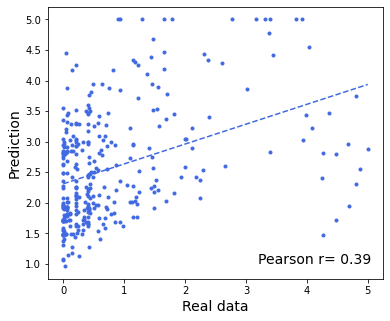

In [464]:
plt.figure(figsize=[6,5])
plt.plot(reals,predictions,'.',color='royalblue')
a,b = np.polyfit(reals,predictions,1)
plt.plot(np.arange(6), np.arange(6)*a+b,'--',color='royalblue')
plt.xlabel('Real data',fontsize=14)
plt.ylabel('Prediction',fontsize=14)
plt.text(3.2,1,'Pearson r= {r:.2f}'.format(r=np.corrcoef(reals,
                [x[0] for x in predictions])[0][1]),fontsize=14)

plt.savefig('app/static/model_perfomance.jpeg')

In [442]:
from sklearn.metrics import r2_score
r2_score(reals,predictions)

-2.557403911060787

In [451]:
from scipy.stats import pearsonr
pearsonr(reals,[x[0] for x in predictions])

(0.39484271732831167, 5.550020182568499e-14)

(-0.3279013394525484, 6.561717325263085, -1.5316262091683308, 5.82769951632451)

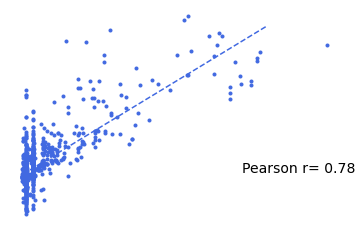

In [233]:
plt.plot(reals,predictions,'.',color='royalblue')
a,b = np.polyfit(reals,predictions,1)
plt.plot(np.arange(6), np.arange(6)*a+b,'--',color='royalblue')
plt.ylabel('Real data',fontsize=14)
plt.xlabel('Prediction',fontsize=14)
plt.text(4.5,0.2,'Pearson r= {r:.2f}'.format(r=np.corrcoef(reals,
                    predictions)[0][1]),fontsize=14)
plt.axis('off')

In [28]:
#kw = list(set([lemmatizer.lemmatize(a) for a,b in pos_tag(text) if b in ['NN','NNS']]))
food = wn.synset('food.n.02')
food_list = list(set([w for s in food.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
#kw = [k for k in kw if re.match(r'^\w\w+$',k) and k in food_list]

In [72]:
def pick_week(t0,z):
    time_series = [t0+datetime.timedelta(days=7*i) for i in range(4)]
    from functools import reduce
    if len(z) == 1:
        sumz = z[0][1][0]+z[0][1][1]
    else:
        sumz = reduce(lambda x,y: x[1][0]+x[1][1]+y[1][0]+y[1][1], z)
    argmax = np.argmax(sumz)
    t1 = time_series[argmax].strftime('%Y-%m-%d')
    t2 = (time_series[argmax]+datetime.timedelta(days=6)).strftime('%Y-%m-%d')
    p1 = '<h3>The best time next month to publish this video is over the week: <h3>'
    p2 = '<h3>'+t1+' to '+t2+'</h3>'
    return p1+p2

In [14]:
def interface(text):
    #text = input()
    kws = identify_keywords(text)
    if not kws:
        return ('please change a title related to FOOD')
    else:
        print ('We detect {} keywords:\n'.format(len(kws)), *kws)
        for kw in kws:
            plt.figure(figsize=[6,4])
            make_figure(kw,3,0)
            make_figure(kw,4,1)
            plt.tight_layout()

In [ ]:
def select_box(kws):
    head = '<div container> <form action = "select",method="get"> <label for="nkw">Choose a keyword:</label><br>  <select id="nkw" name="nkw">'
    content = ' '.join(['<option value="{}">{}</option>'.format(kw,kw) for kw in kws])
    tail = '</select><input type="submit"> </form> </div>'
    return head+content+tail

In [ ]:
identify_keywords(text)

In [29]:
f = glob('app/data/YouTube_titles*.csv')
f.sort()
f1 = pd.read_csv(f[0])
for i in range(1, len(f)):
    f1 = f1.append(pd.read_csv(f[i]),ignore_index=True)

In [30]:
kw_frequency = f1.groupby(by='kw').mean()['viewCount'].sort_values(ascending=False).to_dict()

In [31]:
keywords = f1.groupby(by='kw').mean()['viewCount'].index.values

In [32]:
keywords_food = [k for k in keywords if k in food_list]

In [214]:
keywords_food

['anchovy',
 'apple',
 'atole',
 'aubergine',
 'avocado',
 'baba',
 'bacon',
 'bagel',
 'baguette',
 'baklava',
 'banana',
 'banger',
 'bass',
 'bean',
 'beef',
 'beignet',
 'berry',
 'bird',
 'biscuit',
 'blackberry',
 'bleu',
 'blueberry',
 'bluefin',
 'bologna',
 'brain',
 'bread',
 'brioche',
 'brisket',
 'broccoli',
 'brownie',
 'bun',
 'butter',
 'cabbage',
 'cake',
 'carrot',
 'cauliflower',
 'caviar',
 'cereal',
 'challah',
 'chapati',
 'cheese',
 'cheesecake',
 'cherry',
 'chicken',
 'chickpea',
 'chile',
 'chili',
 'chilli',
 'chipotle',
 'chocolate',
 'chop',
 'clam',
 'cobbler',
 'coconut',
 'cod',
 'cookie',
 'cooky',
 'crab',
 'cracker',
 'cranberry',
 'crepe',
 'croissant',
 'cucumber',
 'cupcake',
 'cut',
 'danish',
 'date',
 'dog',
 'donut',
 'doughnut',
 'duck',
 'dumpling',
 'eater',
 'eclair',
 'eel',
 'eggplant',
 'fennel',
 'filet',
 'fillet',
 'fish',
 'flatbread',
 'fritter',
 'fryer',
 'game',
 'gem',
 'genoise',
 'ghee',
 'gingerbread',
 'gnocchi',
 'gorgonzol

In [158]:
kws = {}
for i in range(len(keywords_food)):
    ratio = get_kw_trend(keywords_food[i])
    ratio = [np.nanmean(r) for r in ratio]
    kws[keywords_food[i]] = ratio

In [159]:
kw = pd.DataFrame(kws,index=list(range(5)))

In [171]:
x, y = np.zeros(100),np.zeros(100)
for i in [3]:
    x = kw.loc[i].values
    x[np.isnan(x)] = 0
    y1 = np.array([np.percentile(x,(j)*4) for j in range(26)])
for i in [4]:
    x = kw.loc[i].values*kw.loc[2].values
    x[np.isnan(x)] = 0
    y2 = np.array([np.percentile(x,(j)*4) for j in range(26)])

In [172]:
y1

array([ 0.12726368,  0.26699296,  0.37837867,  0.48737254,  0.54634302,
        0.62071223,  0.80051461,  0.88242821,  0.9582498 ,  1.06622358,
        1.2621425 ,  1.38800516,  1.54655086,  1.76763256,  1.94942345,
        2.0615092 ,  2.26536604,  2.45091008,  2.71445578,  2.96758879,
        3.49499457,  3.90562174,  4.60420182,  5.97595821,  8.02422907,
       30.48433221])

In [173]:
y2

array([-0.00014885,  0.        ,  0.00067785,  0.00145082,  0.00209637,
        0.00252489,  0.0029149 ,  0.00345558,  0.00391298,  0.00421178,
        0.00447534,  0.00481274,  0.00512605,  0.00536608,  0.00576777,
        0.00598555,  0.00615111,  0.00681535,  0.00723442,  0.00769467,
        0.00820823,  0.00896463,  0.00962756,  0.01082877,  0.01288933,
        0.02032245])

In [107]:
def plot_word_cloud(all_texts):
    # all_texts must be a string 
    covid_wc = WordCloud(
        background_color='white',
        max_words=100,
        width=1000, height=500
        )

    # generate the word cloud
    covid_wc.generate(all_texts)

    # display the word cloud
    plt.imshow(covid_wc, interpolation='bilinear')
    plt.axis('off')

In [108]:
word_list = list(f1.kw.values)
word_list = [i for i in word_list if i not in ['ep','part']]

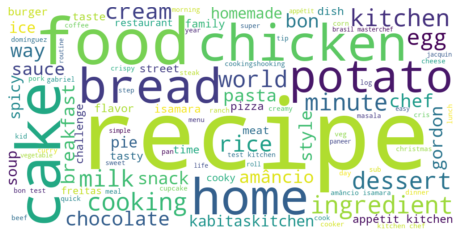

In [109]:
plt.figure(figsize=[8,6])
plot_word_cloud(' '.join(word_list))